In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats
from scipy.special import expit

from theano import tensor as tt

from causalgraphicalmodels import CausalGraphicalModel
import daft

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))

warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2


In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def standardize(array, reference=None):
    if reference is None:
        reference = array
    return (array - reference.mean()) / reference.std() 

The data in data(Achehunting) are 14,364 individual hunting trips by 147 men
among the indigenous Ach  of Paraguay. Each trip has recorded the hunter’s identity
(anonymized id), hunter’s age at the time of the trip, the duration in hours of the
trip, and the kilograms of meat returned. Many of the trips have missing values for
duration.


## Ex. 1

In this first problem, estimate the influence of age on the probability of trip success.
Define “success” as a trip that returns any non-zero amount of meat. Ignore
individual hunter identities for now. You can use any functional relationship for age
and success that you think is sensible, but be sure to justify it and check it against
posterior predictions.

In [16]:
df = pd.read_csv('data/Achehunting.csv', sep=';')
print(df.shape)
df.head()

(14364, 8)


,month,day,year,id,age,kg.meat,hours,datatype
0,10,2.0,1981,3043,67,0.0,6.97,1.0
1,10,3.0,1981,3043,67,0.0,9.00,1.0
2,10,4.0,1981,3043,67,0.0,1.55,1.0
3,10,5.0,1981,3043,67,4.5,8.00,1.0
4,10,6.0,1981,3043,67,0.0,3.00,1.0


In [24]:
df['success'] = np.where(df['kg.meat'] == 0, 0, 1)

df.age.min(), df.age.max()

df = df.sort_values(by='age')


age_id = pd.factorize(df.age)[0]
age_id
age_idx = pd.factorize(df.age)[1]

In [26]:
df.head()

,month,day,year,id,age,kg.meat,hours,datatype,success
13891,10,8.0,2000,4189,11,4.5,NaN,3.0,1
13242,4,26.0,1982,3450,12,0.0,7.1,1.0,0
13241,4,25.0,1982,3450,12,0.6,7.7,1.0,1
13240,4,24.0,1982,3450,12,0.0,9.4,1.0,0
13234,4,18.0,1982,3450,12,0.0,6.7,1.0,0


Model definition: \
We will model age effect using a polynomial term.

In [106]:
#standardize age
age_std = standardize(df.age)

In [117]:
with pm.Model() as m_9_2:
    #intercept
    a = pm.Normal("a", 0.0, 1)

    #slope for age
    b_age =  pm.Normal("b_age", 0.0, 1)

    #linear model with link function
    p = pm.math.invlogit(a + b_age * (age_std**2))

    S = pm.Bernoulli("S", p=p, observed=df['success'])

    trace_9_2 = pm.sample(
        1000, 
        tune=1000,
        target_accept=0.99)

    idata_9_2 = az.from_pymc3(
        trace_9_2
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_age, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [118]:
az.summary(idata_9_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.166,0.022,0.122,0.207,0.001,0.001,929.0,1259.0,1.01
b_age,-0.262,0.016,-0.293,-0.233,0.001,0.000,818.0,1328.0,1.01


In [119]:
un_age_std = np.unique(age_std)

In [121]:
#extract hdis for each datapoint
hdi_low = []
hdi_high = []
for x in un_age_std:
    y = az.hdi(expit(trace_9_2['a'] + trace_9_2['b_age']*(x**2)))[0]
    z = az.hdi(expit(trace_9_2['a'] + trace_9_2['b_age']*(x**2)))[1]
    hdi_low.append(y)
    hdi_high.append(z)

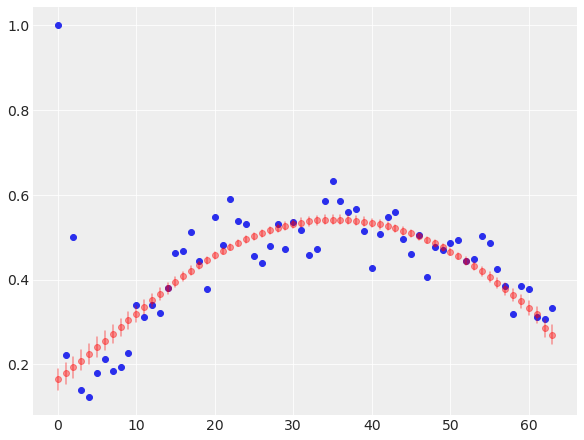

In [124]:
#visualize data and HDIs

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(un_ids, df_grouped['success'], label='raw data') #real data

for x,y in zip(un_ids, un_age_std):
    ax.scatter(x, expit(trace_9_2['a'].mean() + trace_9_2['b_age'].mean()*(y**2)), color='r', alpha=0.4) # mean predictions

for x, lower, upper in zip(un_ids, hdi_low, hdi_high):
    ax.plot((x, x), (lower, upper), color='r', alpha=0.4)



In [114]:
(expit(trace_9_2['a'].mean() + trace_9_2['b_age'].mean()*y + trace_9_2['b_age'].mean()*(y**2)))

0.17552010113715427

In [103]:
trace_9_2['a'].mean() 

0.16727325624678452

# Ex. 2

In [133]:
id = pd.factorize(df.id)[0]
id_idx = pd.factorize(df.id)[1]


In [134]:
with pm.Model() as m_9_3:
    #hyperpriors for individuals
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma_bar = pm.Exponential("sigma_bar", 1)

    #priors for individuals
    a = pm.Normal("a", a_bar, sigma_bar, shape=len(id_idx))

    #age priors
    b_age = pm.Normal('b_age', 0, 1)

    #linear model with link function
    p = pm.math.invlogit(a[id] + b_age * (age_std**2))

    S = pm.Bernoulli("S", p=p, observed=df['success'])

    trace_9_3 = pm.sample(
        1000, 
        tune=1000,
        target_accept=0.99)

    idata_9_3 = az.from_pymc3(
        trace_9_3
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_age, a, sigma_bar, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 190 seconds.


In [136]:
az.summary(idata_9_3, var_names=['a_bar', 'b_age','sigma_bar'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.022,0.070,-0.109,0.150,0.002,0.001,1289.0,2677.0,1.0
b_age,-0.291,0.023,-0.332,-0.245,0.001,0.001,1076.0,2164.0,1.0
sigma_bar,0.576,0.057,0.469,0.681,0.002,0.001,1443.0,2121.0,1.0


We observe substantial differences among individuals (large sigma bar), so a lot of the variation in success seems to be attributed to individual differences.

In [141]:
#correlated varying effects

with pm.Model() as m_9_4_centered:
    #prior stddev in intercepts and slopes (variation accross districts)
    sd_dist = pm.Exponential.dist(0.5)

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True)

    #prior for average intercept (probability of each individual)
    a = pm.Normal("a", mu=0, sd=1.5)

    #prior for average slope (variation by age)
    b = pm.Normal("b", mu=0, sd=1)

    # population of varying effects
    ab_individual = pm.MvNormal(
        "ab_individual", mu=tt.stack([a, b]), chol=chol, shape=(len(id_idx), 2))
    
    # shape needs to be (number of individuals, 2) because we're getting back both a and b for each individual

    # link function

    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ab_individual[id, 0] + ab_individual[id, 1] * (age_std**2)
        ),
    )

    c = pm.Bernoulli("c", p=p, observed=df['success'])

    trace_9_4 = pm.sample(
        1000, 
        tune=1000,
        target_accept=0.99)

    idata_9_4 = az.from_pymc3(
        trace_9_4
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_individual, b, a, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1505 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [143]:
with m_9_4_centered:
    sum = az.summary(idata_9_4,var_names=['a','b','chol_stds','chol_corr'],round_to=2)
sum  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.09,-0.16,0.16,0.00,0.0,2592.55,3232.53,1.00
b,-0.27,0.04,-0.35,-0.20,0.00,0.0,1901.31,2318.61,1.00
chol_stds[0],0.68,0.08,0.54,0.83,0.00,0.0,917.40,1599.10,1.00
chol_stds[1],0.25,0.05,0.16,0.34,0.00,0.0,369.30,507.47,1.01
"chol_corr[0, 0]",1.00,0.00,1.00,1.00,0.00,0.0,4000.00,4000.00,NaN
"chol_corr[0, 1]",-0.56,0.14,-0.80,-0.29,0.01,0.0,765.24,1543.66,1.00
"chol_corr[1, 0]",-0.56,0.14,-0.80,-0.29,0.01,0.0,765.24,1543.66,1.00
"chol_corr[1, 1]",1.00,0.00,1.00,1.00,0.00,0.0,4220.19,3826.99,1.00


In [142]:
df_comp_loo = az.compare(
    {
        "polynom": trace_9_2, 
        "polynom with ind": trace_9_3,
        "polynom with cov": trace_9_4,

        }
        )
df_comp_loo

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
polynom with cov,0,-9459.068250,115.345880,0.000000,0.998286,30.303781,0.000000,False,log
polynom with ind,1,-9482.222303,85.648200,23.154053,0.000000,29.402625,6.458657,False,log
polynom,2,-9800.113304,1.896189,341.045054,0.001714,17.088570,25.305658,False,log
